# Group 12 - Strategy Implementation and Backtesting

## 0. Import packages

If there are any missing packages, you can install them by typing in the code shell:
```terminal
!pip install <package_name>
```
or
```terminal
%pip install <package_name>
```

In [ ]:
import pandas as pd
import numpy as np
import psycopg
import json
import pprint
import mplfinance as mpf

from typing import List
from matplotlib import pyplot as plt
from numpy.testing import assert_almost_equal, assert_equal

                                              0.0/75.0 kB ? eta -:--:--
     --------------------------------         61.4/75.0 kB 1.6 MB/s eta 0:00:01
     ---------------------------------------- 75.0/75.0 kB 1.4 MB/s eta 0:00:00


## 1. Data Preparation
### 1.1. Data Importing
First, we load the data from `yfinance`:

In [95]:
# Load data
with open('database.json', 'rb') as fb:
    db_info = json.load(fb)
conn = psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
)
with psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
) as conn:
    # Open a cursor to perform database operations
    with conn.cursor() as data:
        
        # Execute a query
        data.execute("""
            SELECT m.datetime, m.tickersymbol, m.price
            FROM "quote"."matched" m
            WHERE m.tickersymbol = 'VN30F2301'
            AND m.datetime > '2022-12-31 21:00:00'
        """)

        # Use fetchall() to get all the data of the query.
        # Note: fetchall() can be costly and inefficient.
        # Other efficient ways have been discussed extensively on the Internet. Or you can ask ChatGPT ;)
        dataset = data.fetchall()

        # Print the total number of ticks of that day
        print(f'Total number of tick: {len(dataset)}')

        # Pretty print the first five ticks

Total number of tick: 43879


float64
                           tickersymbol   price
datetime                                       
2023-01-03 08:45:05.220648    VN30F2301   983.0
2023-01-03 08:45:22.691224    VN30F2301   984.2
2023-01-03 08:45:26.760390    VN30F2301   939.0
2023-01-03 08:45:43.239916    VN30F2301   934.2
2023-01-03 08:45:45.270948    VN30F2301   939.0
2023-01-03 08:46:49.194325    VN30F2301   940.0
2023-01-03 08:46:58.575062    VN30F2301   941.0
2023-01-03 08:47:00.596270    VN30F2301   941.8
2023-01-03 08:47:04.648434    VN30F2301   943.0
2023-01-03 08:47:06.683541    VN30F2301   944.0
2023-01-03 08:47:10.959623    VN30F2301   944.2
2023-01-03 08:47:12.791997    VN30F2301   950.0
2023-01-03 08:47:14.825079    VN30F2301   954.0
2023-01-03 08:47:16.039928    VN30F2301   950.0
2023-01-03 08:47:19.089547    VN30F2301   983.0
2023-01-03 08:47:21.128484    VN30F2301   984.6
2023-01-03 08:47:32.524772    VN30F2301   985.0
2023-01-03 08:47:34.566206    VN30F2301   989.0
2023-01-03 08:47:37.604751    VN

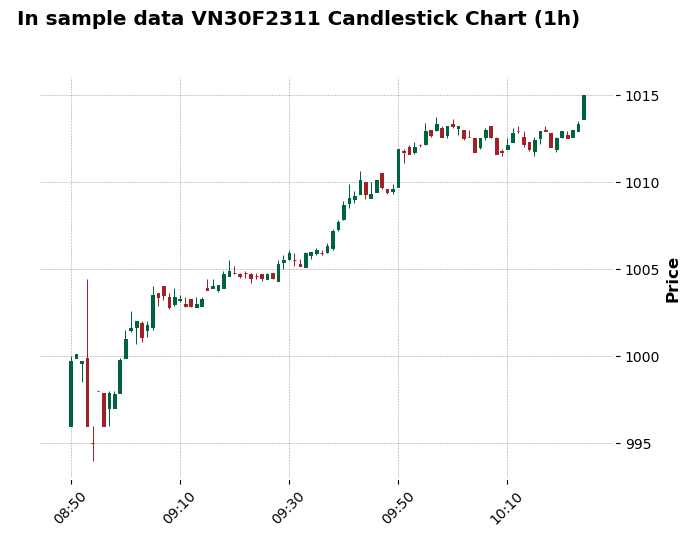

float64
20248 632
                       open    high     low   close
datetime                                           
2023-01-03 08:45:00   983.0   984.2   934.2   939.0
2023-01-03 08:46:00   940.0   941.0   940.0   941.0
2023-01-03 08:47:00   941.8   989.0   941.8   989.0
2023-01-03 08:48:00   985.0   993.1   985.0   993.1
2023-01-03 08:49:00   994.0   995.0   994.0   995.0
2023-01-03 08:50:00   996.0  1000.0   996.0   999.7
2023-01-03 08:51:00   999.9  1000.1   999.9  1000.1
2023-01-03 08:52:00   999.6   999.7   998.5   999.7
2023-01-03 08:53:00   999.9  1004.4   996.0   996.0
2023-01-03 08:54:00   995.0   996.0   994.0   995.0
2023-01-03 08:55:00   998.0   998.0   998.0   998.0
2023-01-03 08:56:00   997.9   997.9   996.0   996.0
2023-01-03 08:57:00   997.0   998.0   996.0   997.9
2023-01-03 08:58:00   997.0   998.0   997.0   997.8
2023-01-03 08:59:00   997.9   999.9   997.9   999.8
2023-01-03 09:00:00   999.9  1001.5   999.9  1001.0
2023-01-03 09:01:00  1001.5  1002.6  1001.4  1

In [114]:
# Devide data into in-sample and out-sample
in_sample_dataset = dataset[:int(len(dataset)*0.8)]
out_sample_dataset = dataset[int(len(dataset)*0.8):]

# Chuyển dữ liệu sang DataFrame của in_sample_data
in_sample_candle = pd.DataFrame(in_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
in_sample_candle['price'] = pd.to_numeric(in_sample_candle['price'], errors='coerce')
print(in_sample_candle['price'].dtype)

# Chuyển đổi cột datetime về kiểu datetime
in_sample_candle['datetime'] = pd.to_datetime(in_sample_candle['datetime'])
in_sample_candle.set_index('datetime', inplace=True)
# sort by datetime
in_sample_candle.sort_index(inplace=True)

print(in_sample_candle[:50])

# Resample dữ liệu theo khung 1 giờ (1h)
in_sample_candle_ohlc = in_sample_candle['price'].resample('1T').ohlc()

# Vẽ biểu đồ nến
mpf.plot(in_sample_candle_ohlc[5:100], type='candle', style='charles',
        title=" In sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price")

# Chuyển dữ liệu sang DataFrame của in_sample_data
out_sample_candle = pd.DataFrame(out_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
out_sample_candle['price'] = pd.to_numeric(out_sample_candle['price'], errors='coerce')
print(out_sample_candle['price'].dtype)
# Chuyển đổi cột datetime về kiểu datetime
out_sample_candle['datetime'] = pd.to_datetime(out_sample_candle['datetime'])
out_sample_candle.set_index('datetime', inplace=True)

# Resample dữ liệu theo khung 1 giờ (1h)
out_sample_candle_ohlc = out_sample_candle['price'].resample('5T').ohlc()

# Vẽ biểu đồ nến
# mpf.plot(out_sample_candle_ohlc[-50:], type='candle', volume=True, style='charles',
#         title=" Out sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price", ylabel_lower="Volume")

print(len(in_sample_candle_ohlc), len(out_sample_candle_ohlc))
print(in_sample_candle_ohlc[0:50])
print(out_sample_candle_ohlc[-10:])

## 2. Trading Algorithm & Backtesting

In [ ]:
import pandas as pd
import numpy as np
# Calculate SMA(50) on the 'close' column.
# Missing candles are simply not in df – the rolling mean is computed over the nearest 50 available candles.
df = in_sample_candle_ohlc.copy()
df['SMA50'] = df['close'].rolling(window=10, min_periods=10).mean()
print(df[50:100])
position = None  # Will hold a dict with keys: type, entry_price, entry_time
trades = []      # List of dicts for each trade
def open_position(position_type, entry_price, entry_time):
    global position
    position = {
        'type': position_type,  # 'long' or 'short'
        'entry_price': entry_price,
        'entry_time': entry_time
    }
    
def close_position(exit_price, exit_time):
    global position, trades
    if position is None:
        return
    trade = position.copy()
    trade['exit_price'] = exit_price
    trade['exit_time'] = exit_time
    if position['type'] == 'long':
        trade['profit'] = exit_price - position['entry_price']
    else:  # For a short position
        trade['profit'] = position['entry_price'] - exit_price
    trades.append(trade)
    print(f"Closed {position['type']} position at {exit_price} on {exit_time} with profit {trade['profit']}")
    position = None

                       open    high     low   close    SMA50
datetime                                                    
2023-01-03 09:35:00  1005.9  1006.2  1005.8  1006.1  1005.46
2023-01-03 09:36:00  1005.9  1006.1  1005.8  1005.9  1005.58
2023-01-03 09:37:00  1006.0  1006.5  1005.9  1006.3  1005.76
2023-01-03 09:38:00  1006.2  1007.3  1006.1  1007.2  1005.95
2023-01-03 09:39:00  1007.3  1007.8  1007.2  1007.7  1006.17
2023-01-03 09:40:00  1007.9  1008.9  1007.8  1008.7  1006.45
2023-01-03 09:41:00  1008.8  1009.9  1008.5  1009.1  1006.81
2023-01-03 09:42:00  1009.0  1009.5  1008.8  1009.2  1007.21
2023-01-03 09:43:00  1009.3  1010.6  1009.3  1010.1  1007.63
2023-01-03 09:44:00  1010.0  1010.0  1009.0  1009.3  1007.96
2023-01-03 09:45:00  1009.1  1010.0  1009.1  1009.3  1008.28
2023-01-03 09:46:00  1009.4  1010.1  1009.4  1010.1  1008.70
2023-01-03 09:47:00  1010.5  1010.5  1009.6  1009.7  1009.04
2023-01-03 09:48:00  1009.6  1009.6  1009.3  1009.4  1009.26
2023-01-03 09:49:00  100

In [ ]:
for i in range(0, len(df)):
    current_candle = df.iloc[i]
    current_time = df.index[i]
    
    # --- Overnight position closing ---
    # If the current candle's date is different from the previous candle's date,
    # close any open position at the previous candle's close.
    if i > 0:
        prev_time = df.index[i-1]
        if current_time.date() != prev_time.date() and position is not None:
            close_position(df.iloc[i-1]['close'], prev_time)
    
    # --- Check for exit conditions if a position is open ---
    if position is not None:
        if position['type'] == 'long':
            unrealized_profit = current_candle['close'] - position['entry_price']
        else:  # For a short position:
            unrealized_profit = position['entry_price'] - current_candle['close']
        # Exit if take profit (>= 3 points) or stop loss (<= -1 point) is reached.
        if unrealized_profit >= 3 or unrealized_profit <= -1:
            close_position(current_candle['close'], current_time)
            continue  # Skip further processing for this candle
    
    # --- If no position, check for an entry signal ---
    if position is None and i >= 3:
        # First, ensure that the three candles before the current one are consecutive (5 mins apart).
        consecutive = (
            (current_time - df.index[i-1] == pd.Timedelta(minutes=1)) and 
            (df.index[i-1] - df.index[i-2] == pd.Timedelta(minutes=1)) and
            (df.index[i-2] - df.index[i-3] == pd.Timedelta(minutes=1))
        )
        if not consecutive:
            # If the candles are not consecutive, skip the pattern check.
            continue
        
        # Get the previous three candles
        prev_candles = df.iloc[i-3:i]
        # Define bearish (red) candle as close < open, bullish (green) as close > open.
        bearish_pattern = all(row['close'] < row['open'] for _, row in prev_candles.iterrows())
        bullish_pattern = all(row['close'] > row['open'] for _, row in prev_candles.iterrows())
        # Ensure SMA50 for current candle is not NaN.
        if np.isnan(current_candle['SMA50']):
            continue
        
        # Entry Signal for Buy (Long):
        # If previous 3 candles are bearish, and the previous candle’s high is below current candle’s close,
        # and the current candle’s close is above the SMA50.
        if bearish_pattern and (df.iloc[i-1]['high'] < current_candle['close']) and (current_candle['SMA50'] < current_candle['close']):
            open_position('long', current_candle['close'], current_time)
        
        # Entry Signal for Sell (Short):
        # If previous 3 candles are bullish, and the previous candle’s low is above current candle’s close,
        # and the current candle’s close is below the SMA50.
        elif bullish_pattern and (df.iloc[i-1]['low'] > current_candle['close']) and (current_candle['SMA50'] > current_candle['close']):
            open_position('short', current_candle['close'], current_time)

# --- End of backtest loop ---
# If any position remains open at the end of the data, close it using the last candle's close.
if position is not None:
    close_position(df.iloc[-1]['close'], df.index[-1])

# =============================================================================
# Trade Summary
# =============================================================================
trades_df = pd.DataFrame(trades)
print("\nBacktesting completed. Trade summary:")
print(trades_df)
total_profit = trades_df['profit'].sum()
print(f"Total profit: {total_profit:.2f}")

Closed long position at 1015.1 on 2023-01-03 10:59:00 with profit 3.1000000000000227
Closed short position at 1016.2 on 2023-01-03 13:00:00 with profit -1.5
Closed short position at 1032.5 on 2023-01-03 14:25:00 with profit -3.7000000000000455
Closed short position at 1045.0 on 2023-01-04 10:14:00 with profit -1.0
Closed short position at 1042.8 on 2023-01-04 13:21:00 with profit 3.2999999999999545
Closed short position at 1046.3 on 2023-01-05 11:18:00 with profit 3.1000000000001364
Closed short position at 1054.6 on 2023-01-05 14:17:00 with profit 3.5
Closed short position at nan on 2023-01-05 23:59:00 with profit nan
Closed long position at 1056.8 on 2023-01-06 09:58:00 with profit 3.099999999999909
Closed long position at 1062.7 on 2023-01-06 10:47:00 with profit -1.099999999999909
Closed short position at 1059.4 on 2023-01-06 13:22:00 with profit 3.199999999999818
Closed short position at 1058.6 on 2023-01-09 10:47:00 with profit 3.1000000000001364
Closed short position at 1057.2 o

## 4. Evaluation